# Классификация ситуаций 

In [133]:
import os

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from sklearn import metrics

from torchvision.models import resnet34, ResNet34_Weights

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import v2
from torchvision import transforms

In [36]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {device} device")

Using cuda device


In [37]:
#приведение данных к виду тренировочных данных ResNet
preprocess = transforms.Compose([ 

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

Чтение и подготовка данных

In [38]:
PATH = 'images/'

def data_loader(path):
    
    x_0 = []
    x_1 = []
    
    for file_name in os.listdir(path):
        
        file_name_split = list(file_name.split('_'))
        img = cv2.imread(path+file_name)
        img = cv2.resize(img, (224, 224)) / 255
        
        if 'violation' in file_name_split:
            
            x_1.append(img)
            
        else:
            
            x_0.append(img)
            
    print("Изображения без опасных ситауций (класс 0): ", len(x_0),
         "\nИзоюражения с опасными ситуациями (класс 1): ", len(x_1))
    
    x_0 = np.array(x_0)
    y_0 = np.zeros(x_0.shape[0])
    
    x_1 = np.array(x_1)
    y_1 = np.ones(x_1.shape[0])
    
    x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_0, y_0, train_size=0.8, random_state=42)
    x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1, y_1, train_size=0.8, random_state=42)
    
    print("\nИзображения класса 0 для тренировки", x_0_train.shape[0], "\nИзображения класса 0 для валидации", x_0_test.shape[0],
         "\nИзображения класса 1 для тренировки", x_1_train.shape[0], "\nИзображения класса 1 для валидации", x_1_test.shape[0])
    
    x_train = np.concatenate((x_0_train, x_1_train), axis=0)
    y_train = np.concatenate((y_0_train, y_1_train), axis=0)
    x_test = np.concatenate((x_0_test, x_1_test), axis=0)
    y_test = np.concatenate((y_0_test, y_1_test), axis=0)
    
    print("\nПолные данные для тренировки", x_train.shape[0], "\nПолные данные для валидации", x_test.shape[0])
    
    x_train = torch.tensor(x_train, dtype=torch.float).permute([0, 3, 1, 2])
    y_train = torch.tensor(y_train, dtype=torch.float)
    x_test = torch.tensor(x_test, dtype=torch.float).permute([0, 3, 1, 2])
    y_test = torch.tensor(y_test, dtype=torch.float)
    
    return preprocess(x_train).to(device), preprocess(x_test).to(device), y_train.to(device), y_test.to(device)

In [39]:
x_train, x_test, y_train, y_test = data_loader(PATH)

Изображения без опасных ситауций (класс 0):  440 
Изоюражения с опасными ситуациями (класс 1):  60

Изображения класса 0 для тренировки 352 
Изображения класса 0 для валидации 88 
Изображения класса 1 для тренировки 48 
Изображения класса 1 для валидации 12

Полные данные для тренировки 400 
Полные данные для валидации 100


Организация тренировочного и валидационного циклов

In [40]:
def train_loop(dataloader, model, criterion, optimizer):
    num_batches = len(dataloader)

    train_loss = 0

    for imgs, labels in dataloader:
        # Compute prediction and loss
        pred = model(imgs.to(device)).to(device)
        #print(pred.squeeze(1).shape, labels)
        loss = criterion(pred.squeeze(1).to(device), labels.to(device))

        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    print(f"Train loss: {train_loss:>8f}")

    return train_loss


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred = model(imgs.to(device)).to(device)
            loss = criterion(pred.squeeze(1).to(device), labels.to(device))

            test_loss += loss.item()
            #print(pred, pred.squeeze(1).round())
            #print(labels)
            correct += (
                (pred.squeeze(1).to(device).round() == labels.to(device)).type(torch.float).sum().item()
            )

    test_loss /= num_batches
    correct /= size
    print(f"Val loss: {test_loss:>8f}, val accuracy: {(100*correct):>0.1f}% \n")

    return test_loss

Для классификации было принято решение использовать ResNet с заменой выходного полногосвязного слоя
на последовательность из слоёв с одним выходом вместо 1000.
Для расчёта ошибки использоваласт бинарная кросс-энтропия. Оптимизатор Adam

In [283]:
model = resnet34(ResNet34_Weights.DEFAULT).to(device)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.AvgPool1d(2), nn.Linear(256, 64), nn.Linear(64, 1))

model = model.to(device)

num_epochs = 70
batch_size = 40
learning_rate = 1e-4


train_dataloader = DataLoader(TensorDataset(x_train,y_train), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TensorDataset(x_test,y_test), batch_size=batch_size, shuffle=False)

pos_weight = torch.tensor([12.0])

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.7, 0.999), eps=1e-08)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)

c:\Users\mijij\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [284]:
loss_history = {"train": [], "test": []}

for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_loss = train_loop(train_dataloader, model, criterion, optimizer)
    test_loss = test_loop(test_dataloader, model, criterion)

    scheduler.step()

    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)

Epoch 1
Train loss: 1.545691
Val loss: 1.936737, val accuracy: 76.0% 

Epoch 2
Train loss: 1.537745
Val loss: 1.913322, val accuracy: 61.0% 

Epoch 3
Train loss: 1.524052
Val loss: 1.908597, val accuracy: 56.0% 

Epoch 4
Train loss: 1.524858
Val loss: 1.892127, val accuracy: 47.0% 

Epoch 5
Train loss: 1.514333
Val loss: 1.942729, val accuracy: 83.0% 

Epoch 6
Train loss: 1.512405
Val loss: 1.883183, val accuracy: 45.0% 

Epoch 7
Train loss: 1.503161
Val loss: 1.891560, val accuracy: 60.0% 

Epoch 8
Train loss: 1.493428
Val loss: 1.906075, val accuracy: 69.0% 

Epoch 9
Train loss: 1.494257
Val loss: 1.890583, val accuracy: 60.0% 

Epoch 10
Train loss: 1.489768
Val loss: 1.887648, val accuracy: 60.0% 

Epoch 11
Train loss: 1.482903
Val loss: 1.900075, val accuracy: 73.0% 

Epoch 12
Train loss: 1.476162
Val loss: 1.891418, val accuracy: 69.0% 

Epoch 13
Train loss: 1.470819
Val loss: 1.892537, val accuracy: 70.0% 

Epoch 14
Train loss: 1.466138
Val loss: 1.870018, val accuracy: 55.0% 

E

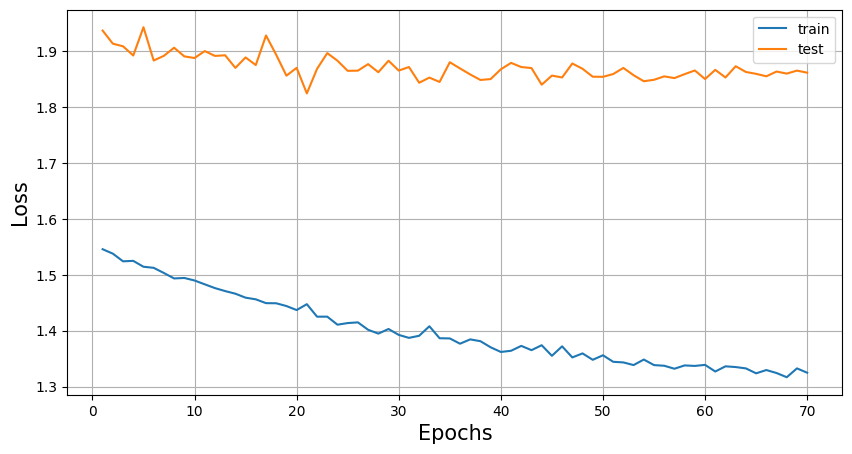

In [285]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.grid()
plt.show()

In [287]:
r = nn.ReLU()
r(model(x_test[-13:-1])).squeeze(1)

tensor([0.5849, 0.0884, 0.0000, 0.4064, 0.0126, 0.6620, 0.3375, 0.0195, 0.1731,
        0.6448, 0.5637, 0.0000], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [291]:
pred = r(model(x_test)).squeeze(1).round().cpu().detach().numpy()
y_test1 = y_test.cpu().detach().numpy()

Для оценки классификации, в отличии от задания 2, нельзя использовать точность, т.к. имеется существенный дисбаланс классов
Для этого использовалась визуализация матрица ошибок, позволяющая оценить классификацию каждого класса отдельно

На основе этой матрицы видно, что точность классификации первого класса мала в относительных единицах, однако в данной конфигурации сети получить большую точность не удалось. Если отталкиваться от того, что важность детекции опасной ситуации значительно больше и лучше неверно классифицировать нулевой класс, то это приводит к тому, что больше половины примеров нулевого класса определяются классом 1. Поэтому было выбрано последнее решение, которое позволяется различить часть опасных ситуаций, при этом относительно верно определяя безопасные.

[[74 14]
 [ 5  7]]


(<Axes: xlabel='Predicted label', ylabel='True label'>,
 array([[74, 14],
        [ 5,  7]], dtype=int64))

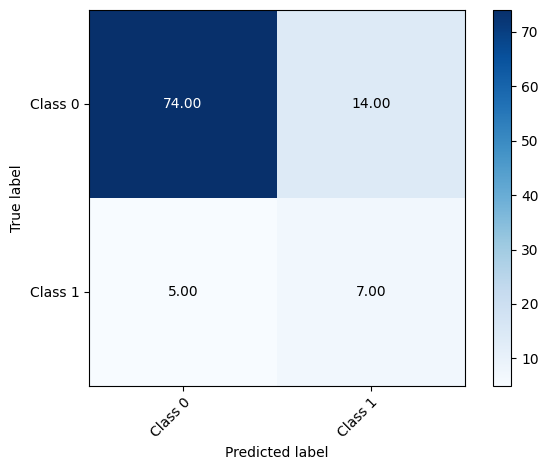

In [292]:
plot_confusion_matrix(y_test1, pred, classes=np.array(["Class 0", "Class 1"]))

In [72]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax, cm

In [ ]:
#torch.save(model.state_dict(), 'model1_state.pth')